# 1. Batch normalization (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.
1. Plot the squared L2 norm of gradients with respect to parameters over the course of training with and without batch normalization. To do this, you will need to compute the gradient of the loss over some data with respect to each parameter, square these gradients, and sum the result across all parameters. You can compute this value at each training step, or after each epoch. What difference does batch normalization make in terms of the squared L2 norm of gradients?

## ResNet Without Batch Normalization

In [1]:
## Train CIFAR10 with PyTorch using ResNet.
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
#from utils import progress_bar

import multiprocessing as mp
from torch import linalg as LA

In [2]:
# ResNet Model without batch-norm

class BasicBlock_without_batchnorm(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_without_batchnorm, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        #out = F.relu(self.bn1(self.conv1(x)))
        #out = self.bn2(self.conv2(out))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet_without_batchnorm(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_without_batchnorm, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18_without_batchnorm():
    return ResNet_without_batchnorm(BasicBlock_without_batchnorm, [2, 2, 2, 2])


In [38]:
# Set up trainning environment 
mp.set_start_method("fork")

#parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
#parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
#parser.add_argument('--resume', '-r', action='store_true',
                    #help='resume from checkpoint')
#args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
losses_nobatchnorm = [] # losses every time for final learning curve
sum_of_grad_list = []

In [39]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [40]:
# set up the model
print('==> Building model..')
net = ResNet18_without_batchnorm()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

#if args.resume:
    # Load checkpoint.
    #print('==> Resuming from checkpoint..')
    #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    #checkpoint = torch.load('./checkpoint/ckpt.pth')
    #net.load_state_dict(checkpoint['net'])
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [41]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    global losses_nobatchnorm
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        sum_grad=0
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # calculate the sum of grad for each epoch
        if batch_idx == 390:
          if isinstance(net, torch.nn.DataParallel):
            net2 = net.module
            for name, param in net2.named_parameters():
              sum_grad = sum_grad + (torch.norm(param,2))**2
            print("squared L2 norm of gradients: %.3f" %sum_grad)
            sum_of_grad_list.append(sum_grad)
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx == 390:
          losses_nobatchnorm.append(train_loss/(batch_idx+1))
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
          #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 99:
              print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
              #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [42]:
for epoch in range(start_epoch, start_epoch+20):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
squared L2 norm of gradients: 5931.502
Loss: 1.522 | Acc: 44.004% (22002/50000)
Loss: 1.332 | Acc: 53.950% (5395/10000)
Saving..

Epoch: 1
squared L2 norm of gradients: 5685.827
Loss: 1.102 | Acc: 60.560% (30280/50000)
Loss: 1.035 | Acc: 63.410% (6341/10000)
Saving..

Epoch: 2
squared L2 norm of gradients: 5547.338
Loss: 0.930 | Acc: 67.156% (33578/50000)
Loss: 0.992 | Acc: 66.060% (6606/10000)
Saving..

Epoch: 3
squared L2 norm of gradients: 5496.396
Loss: 0.826 | Acc: 71.218% (35609/50000)
Loss: 1.031 | Acc: 66.360% (6636/10000)
Saving..

Epoch: 4
squared L2 norm of gradients: 5480.367
Loss: 0.747 | Acc: 74.160% (37080/50000)
Loss: 0.901 | Acc: 69.820% (6982/10000)
Saving..

Epoch: 5
squared L2 norm of gradients: 5487.502
Loss: 0.695 | Acc: 76.064% (38032/50000)
Loss: 0.721 | Acc: 75.090% (7509/10000)
Saving..

Epoch: 6
squared L2 norm of gradients: 5519.712
Loss: 0.657 | Acc: 77.172% (38586/50000)
Loss: 0.752 | Acc: 74.510% (7451/10000)

Epoch: 7
squared L2 norm of gradien

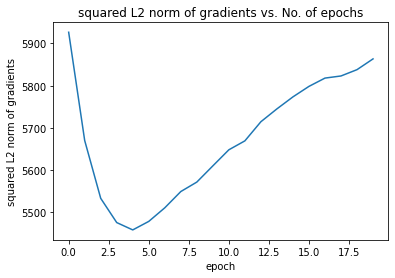

In [8]:
import matplotlib.pyplot as plt
list_plot = [i.detach().cpu().numpy() for i in sum_of_grad_list]
plt.plot(list_plot)
plt.xlabel('epoch')
plt.ylabel('squared L2 norm of gradients')
plt.title('squared L2 norm of gradients vs. No. of epochs')
plt.show()

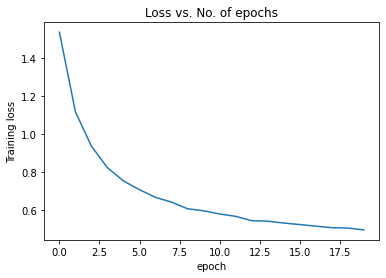

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses_nobatchnorm)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Loss vs. No. of epochs')
plt.show()

## Regular ResNet With Batch Normalization

In [25]:
# ResNet Model

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [26]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [27]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
losses = [] # losses every time for final learning curve
sum_of_grad_list_reg = [] 

In [28]:
# set up the model
print('==> Building model..')
net_reg = ResNet18()
net_reg = net_reg.to(device)
if device == 'cuda':
    net_reg = torch.nn.DataParallel(net_reg)
    cudnn.benchmark = True

#if args.resume:
    # Load checkpoint.
    #print('==> Resuming from checkpoint..')
    #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    #checkpoint = torch.load('./checkpoint/ckpt.pth')
    #net.load_state_dict(checkpoint['net'])
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_reg.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [29]:
# Training
def train_reg(epoch):
    print('\nEpoch: %d' % epoch)
    net_reg.train()
    train_loss = 0
    correct = 0
    total = 0
    global losses
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        sum_grad=0
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_reg(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if batch_idx == 390:
          if isinstance(net, torch.nn.DataParallel):
            net2 = net_reg.module
            for name, param in net2.named_parameters():
              sum_grad = sum_grad + (param.norm(2))**2
            print("squared L2 norm of gradients: %.3f" %sum_grad)
            sum_of_grad_list_reg.append(sum_grad)

        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx == 390:
          losses.append(train_loss/(batch_idx+1))
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
          #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_reg(epoch):
    global best_acc
    net_reg.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_reg(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 99:
              print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
              #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net_reg.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_reg.pth')
        best_acc = acc

In [30]:
for epoch in range(start_epoch, start_epoch+20):
    train_reg(epoch)
    test_reg(epoch)
    scheduler.step()


Epoch: 0
squared L2 norm of gradients: 5266.923
Loss: 2.074 | Acc: 26.818% (13409/50000)
Loss: 1.631 | Acc: 38.440% (3844/10000)
Saving..

Epoch: 1
squared L2 norm of gradients: 3719.032
Loss: 1.536 | Acc: 42.714% (21357/50000)
Loss: 1.474 | Acc: 46.840% (4684/10000)
Saving..

Epoch: 2
squared L2 norm of gradients: 2755.125
Loss: 1.290 | Acc: 52.566% (26283/50000)
Loss: 1.334 | Acc: 54.190% (5419/10000)
Saving..

Epoch: 3
squared L2 norm of gradients: 2162.618
Loss: 1.084 | Acc: 61.314% (30657/50000)
Loss: 1.076 | Acc: 61.370% (6137/10000)
Saving..

Epoch: 4
squared L2 norm of gradients: 1797.670
Loss: 0.947 | Acc: 66.308% (33154/50000)
Loss: 0.954 | Acc: 66.340% (6634/10000)
Saving..

Epoch: 5
squared L2 norm of gradients: 1586.023
Loss: 0.834 | Acc: 70.408% (35204/50000)
Loss: 0.921 | Acc: 68.020% (6802/10000)
Saving..

Epoch: 6
squared L2 norm of gradients: 1472.663
Loss: 0.719 | Acc: 74.790% (37395/50000)
Loss: 1.043 | Acc: 66.350% (6635/10000)

Epoch: 7
squared L2 norm of gradien

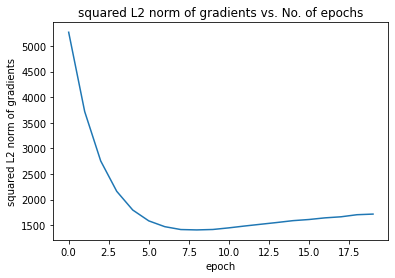

In [31]:
import matplotlib.pyplot as plt
list_plot = [i.detach().cpu().numpy() for i in sum_of_grad_list_reg]
plt.plot(list_plot)
plt.xlabel('epoch')
plt.ylabel('squared L2 norm of gradients')
plt.title('squared L2 norm of gradients vs. No. of epochs')
plt.show()

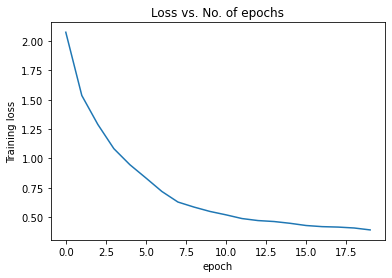

In [32]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Loss vs. No. of epochs')
plt.show()

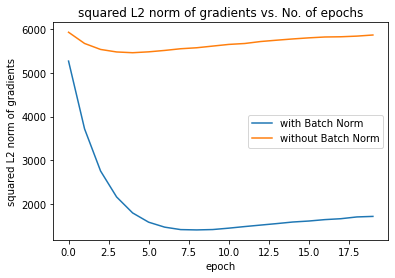

In [33]:
import matplotlib.pyplot as plt
list_plot1 = [i.detach().cpu().numpy() for i in sum_of_grad_list_reg]
list_plot2 = [i.detach().cpu().numpy() for i in sum_of_grad_list]
plt.plot(list_plot1, label="with Batch Norm")
plt.plot(list_plot2, label="without Batch Norm")
plt.xlabel('epoch')
plt.ylabel('squared L2 norm of gradients')
plt.title('squared L2 norm of gradients vs. No. of epochs')
plt.legend()
plt.show()

## Try different learning rates

In [34]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
losses_lr005 = [] # losses every time for final learning curve
sum_of_grad_list_reg_lr005 = [] 

net_reg_lr005 = ResNet18()
net_reg_lr005 = net_reg_lr005.to(device)
if device == 'cuda':
    net_reg_lr005 = torch.nn.DataParallel(net_reg_lr005)
    cudnn.benchmark = True

optimizer_lr005 = optim.SGD(net_reg_lr005.parameters(), lr=0.05,
                      momentum=0.9, weight_decay=5e-4)
# Training
def train_reg_lr005(epoch):
    print('\nEpoch: %d' % epoch)
    net_reg_lr005.train()
    train_loss = 0
    correct = 0
    total = 0
    global losses_lr005
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        sum_grad=0
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_lr005.zero_grad()
        outputs = net_reg_lr005(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if batch_idx == 390:
          if isinstance(net, torch.nn.DataParallel):
            net2 = net_reg_lr005.module
            for name, param in net2.named_parameters():
              sum_grad = sum_grad + (param.norm(2))**2
            print("squared L2 norm of gradients: %.3f" %sum_grad)
            sum_of_grad_list_reg_lr005.append(sum_grad)

        optimizer_lr005.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx == 390:
          losses_lr005.append(train_loss/(batch_idx+1))
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
          #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_reg_lr005(epoch):
    global best_acc
    net_reg_lr005.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_reg_lr005(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 99:
              print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
              #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net_reg_lr005.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_reg_lr005.pth')
        best_acc = acc

for epoch in range(start_epoch, start_epoch+20):
    train_reg_lr005(epoch)
    test_reg_lr005(epoch)
    scheduler.step()


Epoch: 0
squared L2 norm of gradients: 5454.468
Loss: 1.681 | Acc: 38.058% (19029/50000)
Loss: 1.287 | Acc: 52.230% (5223/10000)
Saving..

Epoch: 1
squared L2 norm of gradients: 4648.418
Loss: 1.162 | Acc: 58.022% (29011/50000)
Loss: 0.993 | Acc: 64.890% (6489/10000)
Saving..

Epoch: 2
squared L2 norm of gradients: 3997.082
Loss: 0.899 | Acc: 68.022% (34011/50000)
Loss: 0.934 | Acc: 67.530% (6753/10000)
Saving..

Epoch: 3
squared L2 norm of gradients: 3461.489
Loss: 0.720 | Acc: 74.830% (37415/50000)
Loss: 0.948 | Acc: 67.700% (6770/10000)
Saving..

Epoch: 4
squared L2 norm of gradients: 3020.673
Loss: 0.623 | Acc: 78.378% (39189/50000)
Loss: 0.791 | Acc: 74.250% (7425/10000)
Saving..

Epoch: 5
squared L2 norm of gradients: 2660.554
Loss: 0.547 | Acc: 81.174% (40587/50000)
Loss: 0.591 | Acc: 80.850% (8085/10000)
Saving..

Epoch: 6
squared L2 norm of gradients: 2364.949
Loss: 0.496 | Acc: 83.024% (41512/50000)
Loss: 0.536 | Acc: 81.510% (8151/10000)
Saving..

Epoch: 7
squared L2 norm o

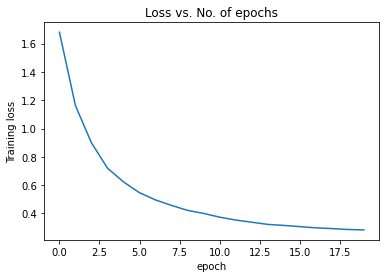

In [35]:
import matplotlib.pyplot as plt
plt.plot(losses_lr005)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Loss vs. No. of epochs')
plt.show()

## Results

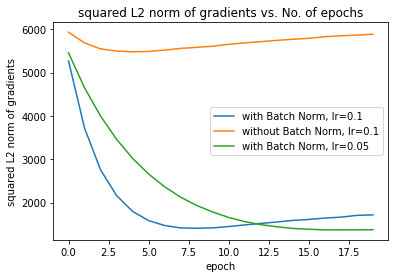

In [67]:
list_plot1 = [i.detach().cpu().numpy() for i in sum_of_grad_list_reg]
list_plot2 = [i.detach().cpu().numpy() for i in sum_of_grad_list]
list_plot3 = [i.detach().cpu().numpy() for i in sum_of_grad_list_reg_lr005]
plt.plot(list_plot1, label="with Batch Norm, lr=0.1")
plt.plot(list_plot2, label="without Batch Norm, lr=0.1")
plt.plot(list_plot3, label="with Batch Norm, lr=0.05")
plt.xlabel('epoch')
plt.ylabel('squared L2 norm of gradients')
plt.title('squared L2 norm of gradients vs. No. of epochs')
plt.legend()
plt.show()

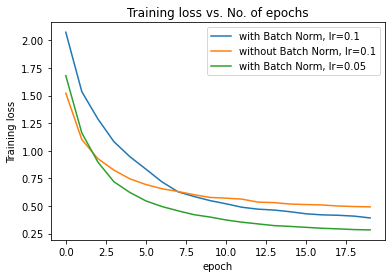

In [50]:
plt.plot(losses, label="with Batch Norm, lr=0.1")
plt.plot(losses_nobatchnorm, label="without Batch Norm, lr=0.1")
plt.plot(losses_lr005, label="with Batch Norm, lr=0.05")
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Training loss vs. No. of epochs')
plt.legend()
plt.show()

ANSWER: 
1. From the training loss vs No. of epochs, we find that using batch norm would increase the training speed, since the model using batch norm would use less epochs to reach lower training loss. Moreover, an appropriate learning rate would further improve the model performance. Here, the model using batch norm and with learning rate of 0.05 is the best among three models. Its training loss descent fastest and achieves the highest accuracy in the testing set. 
2. From the squared L2 norm of gradients vs. No. of epochs, we can see that using batch normalization can effectively reduce the absolute value of the gradients.

# 2. Residual connections (2 points)

Please make use of the model code from Homework 5 question 2 as you work on this question.

If your model didn't use residual connections, add them. If it already had residual connections, remove them. How does the performance change? Please experiment with applying residual connections around different blocks, where a block is a subset of layers (for example, add a residual connection around a single convolution/nonlinearity combination, or a residual connection around two convolution/nonlinearity combinations). Note that you may need to add 1x1 convolutions in the residual path if your block changes the shape (spatial or number of channels) of the input.

## ResNet Model without residual connection

In [51]:
# ResNet Model without residual connection

class BasicBlock_without_connection(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_without_connection, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        #out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet_without_connection(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_without_connection, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18_without_connection():
    return ResNet_without_connection(BasicBlock_without_connection, [2, 2, 2, 2])

In [52]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [53]:
# set up the model
print('==> Building model..')
net_noconnect = ResNet18_without_connection()
net_noconnect = net_noconnect.to(device)
if device == 'cuda':
    net_noconnect = torch.nn.DataParallel(net_noconnect)
    cudnn.benchmark = True

#if args.resume:
    # Load checkpoint.
    #print('==> Resuming from checkpoint..')
    #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    #checkpoint = torch.load('./checkpoint/ckpt.pth')
    #net.load_state_dict(checkpoint['net'])
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_noconnect.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
losses_noconnect = [] # losses every time for final learning curve

In [55]:
# Training
def train_noconnect(epoch):
    print('\nEpoch: %d' % epoch)
    net_noconnect.train()
    train_loss = 0
    correct = 0
    total = 0
    global losses_noconnect
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_noconnect(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx == 390:
          losses_noconnect.append(train_loss/(batch_idx+1))
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
          #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_noconnect(epoch):
    global best_acc
    net_noconnect.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_noconnect(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 99:
              print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
              #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net_noconnect.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_withoutresid.pth')
        best_acc = acc

In [56]:
for epoch in range(start_epoch, start_epoch+20):
    train_noconnect(epoch)
    test_noconnect(epoch)
    scheduler.step()


Epoch: 0
Loss: 1.810 | Acc: 31.594% (15797/50000)
Loss: 1.643 | Acc: 38.870% (3887/10000)
Saving..

Epoch: 1
Loss: 1.475 | Acc: 45.268% (22634/50000)
Loss: 1.440 | Acc: 46.980% (4698/10000)
Saving..

Epoch: 2
Loss: 1.250 | Acc: 54.806% (27403/50000)
Loss: 1.275 | Acc: 54.670% (5467/10000)
Saving..

Epoch: 3
Loss: 1.084 | Acc: 61.160% (30580/50000)
Loss: 1.200 | Acc: 58.040% (5804/10000)
Saving..

Epoch: 4
Loss: 0.966 | Acc: 66.070% (33035/50000)
Loss: 1.043 | Acc: 62.320% (6232/10000)
Saving..

Epoch: 5
Loss: 0.864 | Acc: 69.780% (34890/50000)
Loss: 1.041 | Acc: 64.440% (6444/10000)
Saving..

Epoch: 6
Loss: 0.792 | Acc: 72.730% (36365/50000)
Loss: 0.981 | Acc: 66.650% (6665/10000)
Saving..

Epoch: 7
Loss: 0.736 | Acc: 74.652% (37326/50000)
Loss: 0.814 | Acc: 72.320% (7232/10000)
Saving..

Epoch: 8
Loss: 0.694 | Acc: 76.140% (38070/50000)
Loss: 0.872 | Acc: 70.200% (7020/10000)

Epoch: 9
Loss: 0.648 | Acc: 77.866% (38933/50000)
Loss: 0.782 | Acc: 73.440% (7344/10000)
Saving..

Epoch: 1

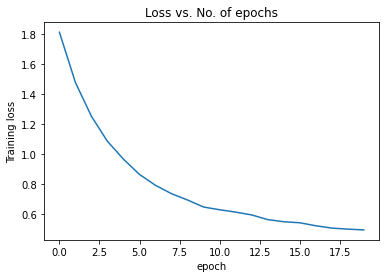

In [57]:
import matplotlib.pyplot as plt
plt.plot(losses_noconnect)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Loss vs. No. of epochs')
plt.show()

## Try different connection blocks

In [58]:
# ResNet Model with connection on every layer

class BasicBlock_everyone(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_everyone, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut1 = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut1 = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

        self.shortcut2 = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut2 = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out += self.shortcut1(x)
        out = F.relu(out)

        out = self.bn2(self.conv2(out))
        out += self.shortcut2(x)
        out = F.relu(out)
        return out



class ResNet_everyone(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_everyone, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18_everyone():
    return ResNet_everyone(BasicBlock_everyone, [2, 2, 2, 2])

In [59]:
# Set up trainning environment 
#mp.set_start_method("fork")

#parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
#parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
#parser.add_argument('--resume', '-r', action='store_true',
                    #help='resume from checkpoint')
#args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
losses_everyone = [] # losses every time for final learning curve

In [60]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [61]:
# set up the model
print('==> Building model..')
net_everyone = ResNet18_everyone()
net_everyone = net_everyone.to(device)
if device == 'cuda':
    net_everyone = torch.nn.DataParallel(net_everyone)
    cudnn.benchmark = True

#if args.resume:
    # Load checkpoint.
    #print('==> Resuming from checkpoint..')
    #assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    #checkpoint = torch.load('./checkpoint/ckpt.pth')
    #net.load_state_dict(checkpoint['net'])
    #best_acc = checkpoint['acc']
    #start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_everyone.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [62]:
# Training
def train_everyone(epoch):
    print('\nEpoch: %d' % epoch)
    net_everyone.train()
    train_loss = 0
    correct = 0
    total = 0
    global losses_everyone
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_everyone(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx == 390:
          losses_everyone.append(train_loss/(batch_idx+1))
          print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
          #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test_everyone(epoch):
    global best_acc
    net_everyone.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_everyone(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 99:
              print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
              #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net_everyone.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_everyone.pth')
        best_acc = acc

In [63]:
for epoch in range(start_epoch, start_epoch+20):
    train_everyone(epoch)
    test_everyone(epoch)
    scheduler.step()


Epoch: 0
Loss: 1.937 | Acc: 32.038% (16019/50000)
Loss: 1.585 | Acc: 42.470% (4247/10000)
Saving..

Epoch: 1
Loss: 1.377 | Acc: 49.456% (24728/50000)
Loss: 1.214 | Acc: 56.360% (5636/10000)
Saving..

Epoch: 2
Loss: 1.083 | Acc: 61.278% (30639/50000)
Loss: 1.154 | Acc: 59.240% (5924/10000)
Saving..

Epoch: 3
Loss: 0.900 | Acc: 68.144% (34072/50000)
Loss: 0.954 | Acc: 67.100% (6710/10000)
Saving..

Epoch: 4
Loss: 0.767 | Acc: 72.822% (36411/50000)
Loss: 0.849 | Acc: 71.260% (7126/10000)
Saving..

Epoch: 5
Loss: 0.669 | Acc: 76.780% (38390/50000)
Loss: 1.006 | Acc: 68.050% (6805/10000)

Epoch: 6
Loss: 0.603 | Acc: 79.234% (39617/50000)
Loss: 0.637 | Acc: 78.130% (7813/10000)
Saving..

Epoch: 7
Loss: 0.559 | Acc: 80.640% (40320/50000)
Loss: 0.637 | Acc: 78.670% (7867/10000)
Saving..

Epoch: 8
Loss: 0.531 | Acc: 81.778% (40889/50000)
Loss: 0.659 | Acc: 77.590% (7759/10000)

Epoch: 9
Loss: 0.506 | Acc: 82.642% (41321/50000)
Loss: 0.631 | Acc: 78.780% (7878/10000)
Saving..

Epoch: 10
Loss: 0

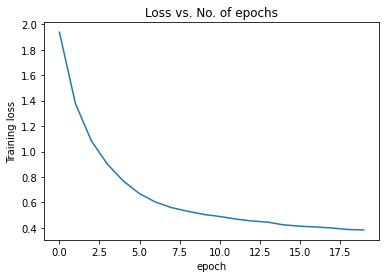

In [64]:
import matplotlib.pyplot as plt
plt.plot(losses_everyone)
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Loss vs. No. of epochs')
plt.show()

## Results

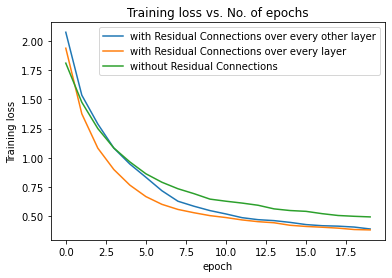

In [66]:
plt.plot(losses, label="with Residual Connections over every other layer")
plt.plot(losses_everyone, label="with Residual Connections over every layer")
plt.plot(losses_noconnect, label="without Residual Connections")
plt.xlabel('epoch')
plt.ylabel('Training loss')
plt.title('Training loss vs. No. of epochs')
plt.legend()
plt.show()

ANSWER: 

From the graph, we can see that using residual connections makes training loss reduce faster. Moreover, using residual connections over every layer helps the model to perform better than using residual connections over every other layer at the begining of the training, but not that much in the end. From the perspective of accuracy, the model using residual connections over every layer performs the best in the testing set, and the model without using residual connections performs the worst. Therefore, residual connections are useful to improve model performance. 